# Tides analysis

I'd like a real-world example to help me learn how to apply fourier transforms. An obvious example that should have a clear periodic signal is data from tides.

My plan:
1. Collect open tidal data from a single specific station
1. Examine the frequency domain of sea depth at that station.

Given that the strongest signal in sea depth should be due to tides, I expect there to be a strong periodic signal corresponding to the twice-daily tide.

In [50]:
import logging
from datetime import datetime, timedelta

import matplotlib
import numpy as np
from scipy import fftpack

# Configure a logger for my own use.
logging.basicConfig()
log = logging.getLogger("tides_analysis")
log.setLevel(level=logging.DEBUG)
# Configure `requests` to be loud. That library has useful
# log messages, so I like to to be as noisy as it wants to be.
logging.getLogger("urllib3").setLevel(level=logging.DEBUG)

## Collect data

* Tide data are available via an API [here](https://api.tidesandcurrents.noaa.gov/api/prod/?station=9414290#requestResponse)
* You can find IDs for specific stations [here](https://tidesandcurrents.noaa.gov/)
    * In my case, I'll chose the station at [Port Townsend, WA (ID: 9444900)](https://tidesandcurrents.noaa.gov/map/index.html?id=9444900)
* In order to request data from this API, you must specify the "datum" you want.
    * Information about datums can be found [here](https://en.wikipedia.org/wiki/Chart_datum).
    * Essentially, the datum defines the base water level against which tide depths are measured.
    * The list of supported datums is [here](https://api.tidesandcurrents.noaa.gov/api/prod/?station=9414290#datum).
    * Datum values for all stations is listed [here](https://tidesandcurrents.noaa.gov/stations.html?type=Datums). Port Townsend datum is [here](https://tidesandcurrents.noaa.gov/datums.html?id=9444900).
    * We'll use Mean Lower Low Water (MLLW). As defined [here](https://tidesandcurrents.noaa.gov/datum_options.html#:~:text=A%20tidal%20datum%20is%20a,oceanographic%20characteristics%20without%20substantiating%20measurements.): "The average of the lower low water height of each tidal day observed over the National Tidal Datum Epoch."
        * Note: "National Tidal Datum Epoch" is described [here](https://tidesandcurrents.noaa.gov/datum-updates/ntde/#:~:text=The%20National%20Tidal%20Datum%20Epoch,%2C%20mean%20lower%20low%20water). It's a 19-year time period from 1983 through 2001.

In [3]:
import requests
import pandas as pd

# Request data
resp = requests.get(
    "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter",
    params={
        "begin_date": "20100101",
        "end_date": "20100131",
        "station": "9444900",
        "product": "water_level",
        "datum": "MLLW",
        "units": "english",
        "time_zone": "gmt",
        "application": "THoM",
        "format": "json",
    }
)
resp.raise_for_status()
data = resp.json()

log.info("Metadata for station: {}".format(data["metadata"]))

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.tidesandcurrents.noaa.gov:443
DEBUG:urllib3.connectionpool:https://api.tidesandcurrents.noaa.gov:443 "GET /api/prod/datagetter?begin_date=20100101&end_date=20100131&station=9444900&product=water_level&datum=MLLW&units=english&time_zone=gmt&application=THoM&format=json HTTP/1.1" 200 52766
INFO:tides_analysis:Metadata for station: {'id': '9444900', 'name': 'Port Townsend', 'lat': '48.1129', 'lon': '-122.7595'}


In [14]:
# Build dataframe
df = (
    pd.DataFrame(data=data["data"])
    .set_index(keys="t", verify_integrity=True)
)

df.index = pd.to_datetime(df.index)
df["v"] = df["v"].astype("float64")
df["s"] = df["s"].astype("float64")

df

v      s        f  q
t                                            
2010-01-01 00:00:00  8.532  0.026  0,0,0,0  v
2010-01-01 00:06:00  8.378  0.023  0,0,0,0  v
2010-01-01 00:12:00  8.236  0.026  0,0,0,0  v
2010-01-01 00:18:00  8.069  0.026  0,0,0,0  v
2010-01-01 00:24:00  7.905  0.026  0,0,0,0  v
...                    ...    ...      ... ..
2010-01-31 23:30:00  8.706  0.023  0,0,0,0  v
2010-01-31 23:36:00  8.765  0.016  0,0,0,0  v
2010-01-31 23:42:00  8.811  0.026  0,0,0,0  v
2010-01-31 23:48:00  8.857  0.016  0,0,0,0  v
2010-01-31 23:54:00  8.880  0.023  0,0,0,0  v

[7440 rows x 4 columns]

## Basic plots of time domain

Let's take a look at the data we're dealing with.

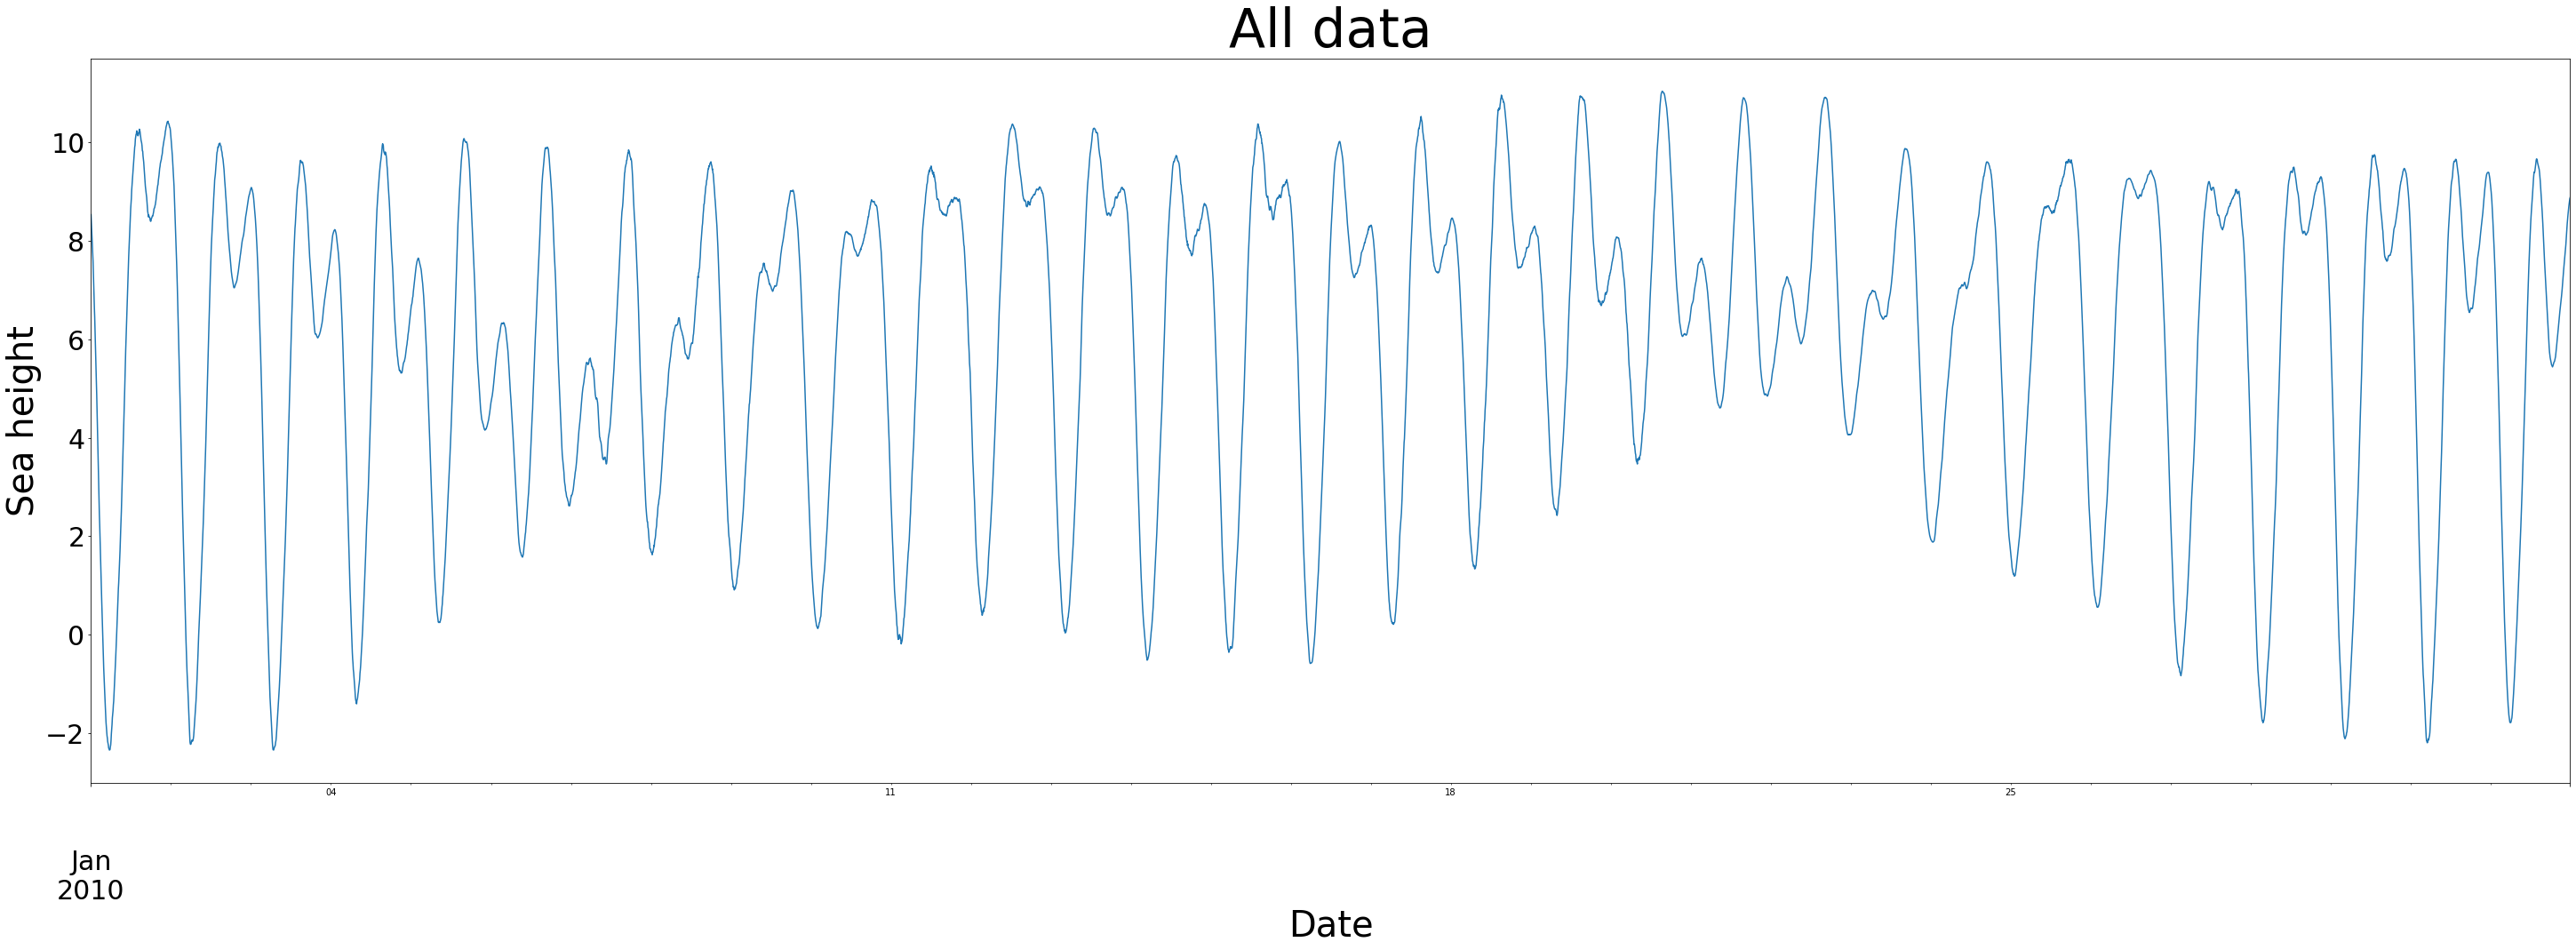

In [22]:
ax = df["v"].plot(figsize=(50, 15))
ax.set_title("All data", fontsize=60)
ax.set_xlabel("Date", fontsize=40)
ax.set_ylabel("Sea height", fontsize=40)
ax.tick_params(labelsize=30)

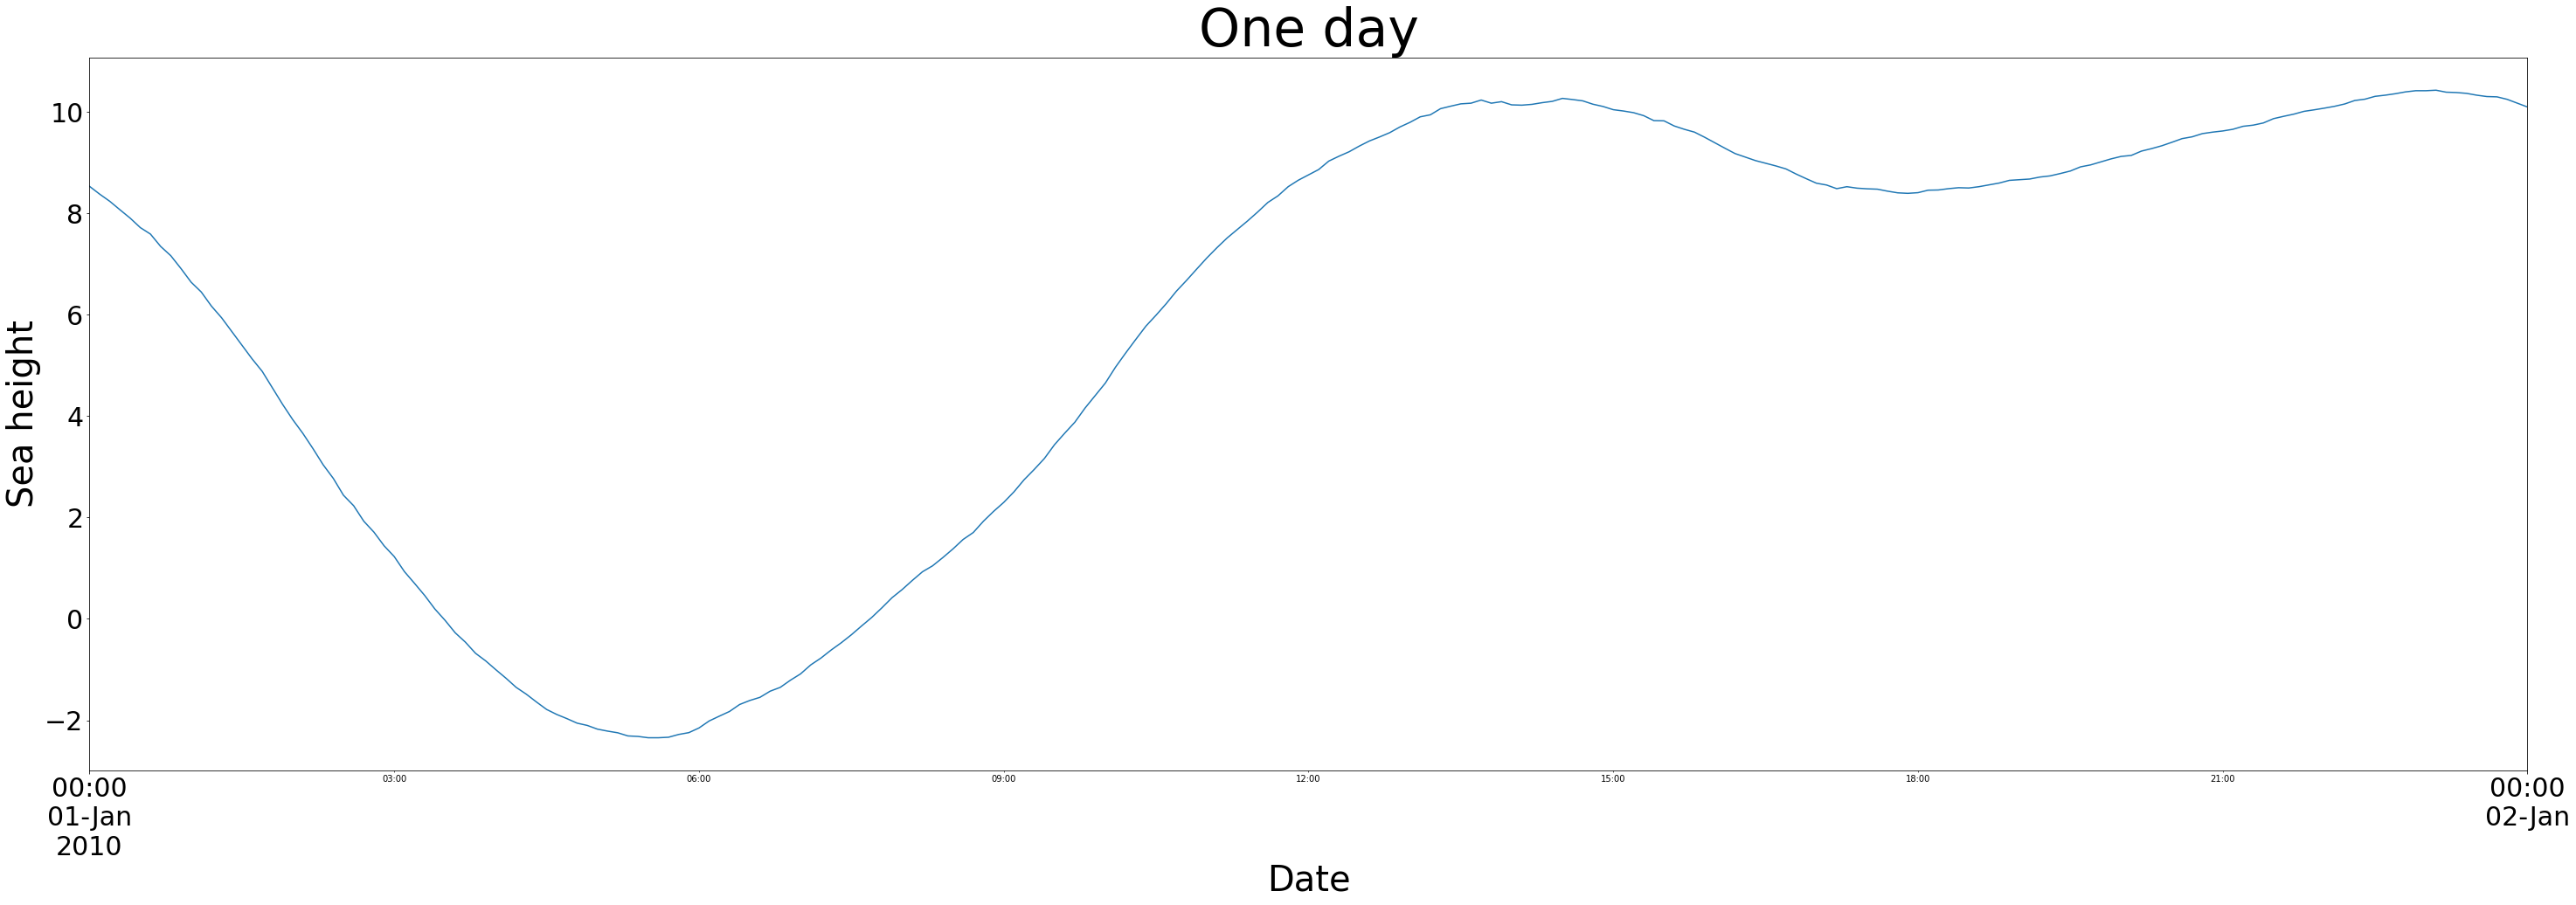

In [25]:
date_to_plot = datetime(year=2010, month=1, day=1)

ax = df[date_to_plot : date_to_plot + timedelta(days=1)]["v"].plot(figsize=(50, 15))
ax.set_title("One day", fontsize=60)
ax.set_xlabel("Date", fontsize=40)
ax.set_ylabel("Sea height", fontsize=40)
ax.tick_params(labelsize=30)

## Determine measurement frequency

In order to run the fourier transform, we need to know how frequently the measurements are taken. Let's figure this out.

In [46]:
dates_in_data = df.reset_index()["t"]

dates_in_data["time_since_last_measurement"] = dates_in_data - dates_in_data.shift(1)

# Check that there's only one timedelta across all the data
timedelta_groups = dates_in_data.groupby("time_since_last_measurement")
assert timedelta_groups.ngroups == 1

# We've confirmed that there's a consistent amount of time
# between every measurement in the data. Let's get that value.
measurement_timedelta, = timedelta_groups.groups.keys()

log.info("The time between measurements is: {}".format(measurement_timedelta))
hours_between_measurements = measurement_timedelta.total_seconds() / (60 * 60)
log.info("There are {} hours between each measurement.".format(hours_between_measurements))

INFO:tides_analysis:The time between measurements is: 0 days 00:06:00
INFO:tides_analysis:There are 0.1 hours between each measurement.


As shown above, the station takes measurements every 6 minutes. That's a whole lot of data. Our goal is to just capture the two tides each day and any lower-frequency events (e.g., monthly/yearly variations). What measurement frequency do we actually need?
* Perhaps some help/techniques can be found [here](https://en.wikipedia.org/wiki/Nyquist_frequency)

## Run Fourier Analysis

Time to run the actual analysis

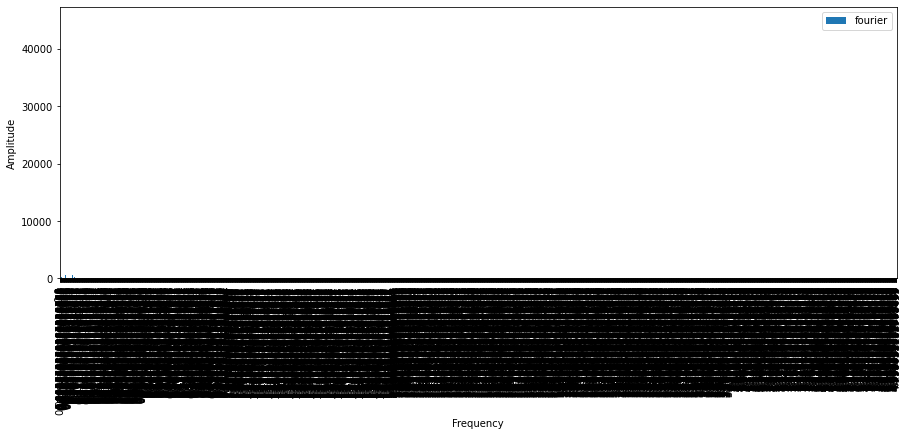

In [56]:
# Calculate the frequency domain.
freq_domain = np.fft.fft(df["v"].values)
x = fftpack.fftfreq(freq_domain.size, hours_between_measurements)

fft_df = (
    pd.DataFrame(
        index=x[:x.size // 2],
        data=freq_domain[:freq_domain.size // 2]
    )
    .abs()
    .rename({0: "fourier"}, axis=1)
)
ax = fft_df.plot.bar(figsize=(15, 5), xlabel="Frequency", ylabel="Amplitude")
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=np.pi / 2))